In [1]:
import pandas as pd
import string
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy import signal
import os
import sys
import seaborn
import notebook as nb
import math
import dask
import dask.dataframe as dk
import datetime as dt
import random
import gc
%matplotlib inline

with open('./openings.txt','r') as f:
    lines = f.readlines()
newlines = []
for i,line in enumerate(lines):
    eco = line.split()[0]
    rest = ' '.join(line.split()[1:])
    name = rest.split('1')[0]
    position = '1'+rest.split('1')[1]
    newline = '    '.join([eco,name,position])
    newlines.append(newline)
with open('./openings-adjust.txt','w') as f:
    for line in newlines:
        f.write(line+'\n')

openings = pd.read_csv('openings-adjust.txt', sep='    ', names=['ECO','Opening_Name','Moves'], engine='python')

openings

def generic_position(moves):
    A = moves.replace('1.','').replace('2.','').replace('3.','').replace('4.','').replace('5.','').split()
    for i,a in enumerate(A):
        if i%2 == 0:
            A[i] = 'W.'+ A[i]
        else:
            A[i] = 'B.'+ A[i]
    return set(A)

openings.loc[:,'Generic_Position'] = openings.Moves.apply(generic_position)

openings

df0 = pd.read_csv('all_with_filtered_anotations_since1998.txt',
                  skiprows=5, sep=' ', usecols = [i for i in range(1,16)], 
                  names=['date', 'result', 'welo', 'belo', 'len', 'date_c', 
                         'resu_c', 'welo_c', 'belo_c', 'edate_c', 'setup', 'fen', 
                         'resu2_c', 'oyrange', 'bad_len'],
                  parse_dates = ['date'], infer_datetime_format = True,
                  dtype = {'date':object, 'result':'category', 'welo':'float64',
                          'belo':'float64', 'len':'float64', 'date_c':'category',
                          'resu_c':'category', 'welo_c':'category', 'belo_c':'category',
                          'edate_c':'category', 'setup':'category', 'fen':'category',
                          'resu2_c':'category', 'oyrange':'category', 'bad_len':'category'},
                 na_values=['None'])

df1 = pd.read_csv('all_with_filtered_anotations_since1998.txt',
                  skiprows=5, header=None, sep='###', usecols = [1], names=['Game'], 
                  engine='python')

df = df0.join(df1)

df.head()

def determine_opening(game,opening_df):
    if type(game) == float:
        #print(game)
        return None
    else:
        for i in range(10,0,-1):
            #print(game)
            opening = game.split()[:i]
            for i,move in enumerate(opening):
                ply = i//2+1
                opening[i] = move.replace(str(ply)+'.','.')
            #print(opening)

            name = opening_df.loc[opening_df['Generic_Position'] == set(opening),'Opening_Name']#.iloc[0]
            #print(name)
            if name.size == 0:
                continue
            else:
                return name.iloc[0]
                break

%time determine_opening(df.loc[3,'Game'],openings)

dfdates = df[df['date_c']=='date_false']

len(dfdates)

dfdates.loc[:,'Opening'] = dfdates.Game.apply(determine_opening, opening_df=openings)

dfdates.head()

dfdates.loc[:,'year'] = dfdates.date.apply(lambda d: int(d.split('.')[0]))

dfdates.head()

dfdates.year.max()

dfdates.reset_index(inplace=True)

bins = dfdates.groupby([pd.cut(dfdates.year,bins=[1790,1820,1850,1880,1910,1940,1970,1990,2010]),'Opening'])['index'].count()

bins = pd.DataFrame(bins)

bins

tot = bins.groupby('year').sum()
tot

props = []
for group,dfb in bins.groupby('year'):
    prop = dfb.nlargest(5,'index')
    prop['proportion'] = prop['index']/tot.loc[group,'index']
    props.append(prop)
proportions = pd.concat(props)

proportions

seaborn.set(context="poster", style="white", font_scale=1.4)

proportions.plot.bar(y='proportion', figsize=(20,10))

means = dfdates.groupby('Opening').describe()['len']

l = means.nlargest(5,'mean')
s = means.nsmallest(5,'mean')
lenstats = pd.concat([l,s])

ddf = dfdates[dfdates.Opening.isin(lenstats.index)]
ddf

ddf.boxplot(by='Opening',column=['len'],rot=90,figsize=(20,15))

In [35]:
with open('./openings.txt','r') as f:
    lines = f.readlines()
newlines = []
for i,line in enumerate(lines):
    eco = line.split()[0]
    rest = ' '.join(line.split()[1:])
    name = rest.split('1')[0]
    position = '1'+rest.split('1')[1]
    newline = '    '.join([eco,name,position])
    newlines.append(newline)
with open('./openings-adjust.txt','w') as f:
    for line in newlines:
        f.write(line+'\n')

In [53]:
openings = pd.read_csv('openings-adjust.txt', sep='    ', names=['ECO','Opening_Name','Moves'], engine='python')

In [54]:
openings

,ECO,Opening_Name,Moves
0,A00,Polish (Sokolsky) opening,1. b4
1,A01,Nimzovich-Larsen attack,1. b3
2,A02-A03,Bird's opening,1. f4
3,A04-A09,Reti opening,1. Nf3
4,A10-A39,English opening,1. c4
5,A40-A41,Queen's pawn,1. d4
6,A42,"Modern defence, Averbakh system",1. d4 d6 2. c4 g6 3. Nc3 Bg7 4. e4
7,A43-A44,Old Benoni defence,1. d4 c5
8,A45-A46,Queen's pawn game,1. d4 Nf6
9,A47,Queen's Indian defence,1. d4 Nf6 2. Nf3 b6


In [78]:
def generic_position(moves):
    A = moves.replace('1.','').replace('2.','').replace('3.','').replace('4.','').replace('5.','').split()
    for i,a in enumerate(A):
        if i%2 == 0:
            A[i] = 'W.'+ A[i]
        else:
            A[i] = 'B.'+ A[i]
    return set(A)

In [79]:
openings.loc[:,'Generic_Position'] = openings.Moves.apply(generic_position)

In [80]:
openings

,ECO,Opening_Name,Moves,Generic_Position
0,A00,Polish (Sokolsky) opening,1. b4,{W.b4}
1,A01,Nimzovich-Larsen attack,1. b3,{W.b3}
2,A02-A03,Bird's opening,1. f4,{W.f4}
3,A04-A09,Reti opening,1. Nf3,{W.Nf3}
4,A10-A39,English opening,1. c4,{W.c4}
5,A40-A41,Queen's pawn,1. d4,{W.d4}
6,A42,"Modern defence, Averbakh system",1. d4 d6 2. c4 g6 3. Nc3 Bg7 4. e4,"{B.d6, W.e4, W.d4, B.g6, W.Nc3, B.Bg7, W.c4}"
7,A43-A44,Old Benoni defence,1. d4 c5,"{W.d4, B.c5}"
8,A45-A46,Queen's pawn game,1. d4 Nf6,"{W.d4, B.Nf6}"
9,A47,Queen's Indian defence,1. d4 Nf6 2. Nf3 b6,"{W.d4, B.Nf6, B.b6, W.Nf3}"


In [293]:
df0 = pd.read_csv('all_with_filtered_anotations_since1998.txt',
                  skiprows=5, sep=' ', usecols = [i for i in range(1,16)], 
                  names=['date', 'result', 'welo', 'belo', 'len', 'date_c', 
                         'resu_c', 'welo_c', 'belo_c', 'edate_c', 'setup', 'fen', 
                         'resu2_c', 'oyrange', 'bad_len'],
                  parse_dates = ['date'], infer_datetime_format = True,
                  dtype = {'date':object, 'result':'category', 'welo':'float64',
                          'belo':'float64', 'len':'float64', 'date_c':'category',
                          'resu_c':'category', 'welo_c':'category', 'belo_c':'category',
                          'edate_c':'category', 'setup':'category', 'fen':'category',
                          'resu2_c':'category', 'oyrange':'category', 'bad_len':'category'},
                 na_values=['None'])

In [294]:
df1 = pd.read_csv('all_with_filtered_anotations_since1998.txt',
                  skiprows=5, header=None, sep='###', usecols = [1], names=['Game'], 
                  engine='python')

In [295]:
df = df0.join(df1)

In [6]:
df.head()

,date,result,welo,belo,len,date_c,resu_c,welo_c,belo_c,edate_c,setup,fen,resu2_c,oyrange,bad_len,Game
0,2000.03.14,1-0,2851.0,NaN,67.0,date_false,result_false,welo_false,belo_true,edate_true,setup_false,fen_false,result2_false,oyrange_false,blen_false,W1.d4 B1.d5 W2.c4 B2.e6 W3.Nc3 B3.Nf6 W4.cxd5...
1,2000.03.14,1-0,2851.0,NaN,53.0,date_false,result_false,welo_false,belo_true,edate_true,setup_false,fen_false,result2_false,oyrange_false,blen_false,W1.e4 B1.d5 W2.exd5 B2.Qxd5 W3.Nc3 B3.Qa5 W4....
2,1999.11.20,1-0,2851.0,NaN,57.0,date_false,result_false,welo_false,belo_true,edate_false,setup_false,fen_false,result2_false,oyrange_false,blen_false,W1.e4 B1.e5 W2.Nf3 B2.Nc6 W3.Bc4 B3.Bc5 W4.c3...
3,1999.11.20,1-0,2851.0,NaN,49.0,date_false,result_false,welo_false,belo_true,edate_false,setup_false,fen_false,result2_false,oyrange_false,blen_false,W1.e4 B1.d5 W2.exd5 B2.Qxd5 W3.Nc3 B3.Qa5 W4....
4,2000.02.20,1/2-1/2,2851.0,2633.0,97.0,date_false,result_false,welo_false,belo_false,edate_false,setup_false,fen_false,result2_false,oyrange_false,blen_false,W1.e4 B1.e5 W2.Nf3 B2.Nc6 W3.Bb5 B3.a6 W4.Ba4...


In [205]:
def determine_opening(game,opening_df):
    if type(game) == float:
        #print(game)
        return None
    else:
        for i in range(10,0,-1):
            #print(game)
            opening = game.split()[:i]
            for i,move in enumerate(opening):
                ply = i//2+1
                opening[i] = move.replace(str(ply)+'.','.')
            #print(opening)

            name = opening_df.loc[opening_df['Generic_Position'] == set(opening),'Opening_Name']#.iloc[0]
            #print(name)
            if name.size == 0:
                continue
            else:
                return name.iloc[0]
                break

In [206]:
%time determine_opening(df.loc[3,'Game'],openings)

Wall time: 4.02 ms


'Scandinavian (centre counter) defence'

In [180]:
dfdates = df[df['date_c']=='date_false']

In [181]:
len(dfdates)

1549514

In [207]:
dfdates.loc[:,'Opening'] = dfdates.Game.apply(determine_opening, opening_df=openings)

C:\Users\Adam\Miniconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Adam\Miniconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [208]:
dfdates.head()

,date,result,welo,belo,len,date_c,resu_c,welo_c,belo_c,edate_c,setup,fen,resu2_c,oyrange,bad_len,Game,Opening
0,2000.03.14,1-0,2851.0,NaN,67.0,date_false,result_false,welo_false,belo_true,edate_true,setup_false,fen_false,result2_false,oyrange_false,blen_false,W1.d4 B1.d5 W2.c4 B2.e6 W3.Nc3 B3.Nf6 W4.cxd5...,Queen's gambit declined
1,2000.03.14,1-0,2851.0,NaN,53.0,date_false,result_false,welo_false,belo_true,edate_true,setup_false,fen_false,result2_false,oyrange_false,blen_false,W1.e4 B1.d5 W2.exd5 B2.Qxd5 W3.Nc3 B3.Qa5 W4....,Scandinavian (centre counter) defence
2,1999.11.20,1-0,2851.0,NaN,57.0,date_false,result_false,welo_false,belo_true,edate_false,setup_false,fen_false,result2_false,oyrange_false,blen_false,W1.e4 B1.e5 W2.Nf3 B2.Nc6 W3.Bc4 B3.Bc5 W4.c3...,Giuoco Piano
3,1999.11.20,1-0,2851.0,NaN,49.0,date_false,result_false,welo_false,belo_true,edate_false,setup_false,fen_false,result2_false,oyrange_false,blen_false,W1.e4 B1.d5 W2.exd5 B2.Qxd5 W3.Nc3 B3.Qa5 W4....,Scandinavian (centre counter) defence
4,2000.02.20,1/2-1/2,2851.0,2633.0,97.0,date_false,result_false,welo_false,belo_false,edate_false,setup_false,fen_false,result2_false,oyrange_false,blen_false,W1.e4 B1.e5 W2.Nf3 B2.Nc6 W3.Bb5 B3.a6 W4.Ba4...,Ruy Lopez (Spanish opening)


In [222]:
dfdates.loc[:,'year'] = dfdates.date.apply(lambda d: int(d.split('.')[0]))

C:\Users\Adam\Miniconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Adam\Miniconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [227]:
dfdates.head()

,date,result,welo,belo,len,date_c,resu_c,welo_c,belo_c,edate_c,setup,fen,resu2_c,oyrange,bad_len,Game,Opening,year
0,2000.03.14,1-0,2851.0,NaN,67.0,date_false,result_false,welo_false,belo_true,edate_true,setup_false,fen_false,result2_false,oyrange_false,blen_false,W1.d4 B1.d5 W2.c4 B2.e6 W3.Nc3 B3.Nf6 W4.cxd5...,Queen's gambit declined,2000
1,2000.03.14,1-0,2851.0,NaN,53.0,date_false,result_false,welo_false,belo_true,edate_true,setup_false,fen_false,result2_false,oyrange_false,blen_false,W1.e4 B1.d5 W2.exd5 B2.Qxd5 W3.Nc3 B3.Qa5 W4....,Scandinavian (centre counter) defence,2000
2,1999.11.20,1-0,2851.0,NaN,57.0,date_false,result_false,welo_false,belo_true,edate_false,setup_false,fen_false,result2_false,oyrange_false,blen_false,W1.e4 B1.e5 W2.Nf3 B2.Nc6 W3.Bc4 B3.Bc5 W4.c3...,Giuoco Piano,1999
3,1999.11.20,1-0,2851.0,NaN,49.0,date_false,result_false,welo_false,belo_true,edate_false,setup_false,fen_false,result2_false,oyrange_false,blen_false,W1.e4 B1.d5 W2.exd5 B2.Qxd5 W3.Nc3 B3.Qa5 W4....,Scandinavian (centre counter) defence,1999
4,2000.02.20,1/2-1/2,2851.0,2633.0,97.0,date_false,result_false,welo_false,belo_false,edate_false,setup_false,fen_false,result2_false,oyrange_false,blen_false,W1.e4 B1.e5 W2.Nf3 B2.Nc6 W3.Bb5 B3.a6 W4.Ba4...,Ruy Lopez (Spanish opening),2000


In [224]:
dfdates.year.max()

2007

In [231]:
dfdates.reset_index(inplace=True)

In [232]:
bins = dfdates.groupby([pd.cut(dfdates.year,bins=[1790,1820,1850,1880,1910,1940,1970,1990,2010]),'Opening'])['index'].count()

In [251]:
bins = pd.DataFrame(bins)

In [255]:
bins

index  tot
year         Opening                                                        
(1790, 1820] French defence                                           2  NaN
             King's gambit                                            6  NaN
             King's pawn opening                                      8  NaN
(1820, 1850] Bird's opening                                           1  NaN
             Bishop's opening                                        17  NaN
             Centre game                                              4  NaN
             Dutch                                                    5  NaN
             English opening                                          4  NaN
             Evans gambit                                            19  NaN
             French defence                                           8  NaN
             Giuoco Piano                                            16  NaN
             King's gambit                                           43  NaN
             King's knight opening                                    1  NaN
             King's pawn game                                        21  NaN
             King's pawn opening                                      1  NaN
             Nimzovich-Larsen attack                                  1  NaN
             Petrov's defence                                         2  NaN
             Philidor's defence                                       9  NaN
             Queen's Gambit Declined Slav defence                     1  NaN
             Queen's Gambit Declined, Chigorin defence                3  NaN
             Queen's gambit accepted                                 16  NaN
             Queen's gambit declined                                  2  NaN
             Queen's pawn                                             4  NaN
             Queen's pawn game                                        2  NaN
             Ruy Lopez (Spanish opening)                              3  NaN
             Scandinavian (centre counter) defence                    3  NaN
             Scotch game                                              3  NaN
             Sicilian defence                                        18  NaN
             Three knights game                                       2  NaN
             Two knights defence                                      3  NaN
...                                                                 ...  ...
(1990, 2010] Nimzovich-Larsen attack                               6210  NaN
             Old Benoni defence                                    7061  NaN
             Old Indian defence                                    5399  NaN
             Petrov's defence                                     16548  NaN
             Philidor's defence                                    7603  NaN
             Pirc defence                                         24236  NaN
             Polish (Sokolsky) opening                             3426  NaN
             Queen's Gambit                                        4504  NaN
             Queen's Gambit Declined Slav accepted, Alapin v...    1021  NaN
             Queen's Gambit Declined Slav defence                 27119  NaN
             Queen's Gambit Declined Slav, Czech defence           5200  NaN
             Queen's Gambit Declined semi-Slav                    14888  NaN
             Queen's Gambit Declined, 4.Bg5                        9384  NaN
             Queen's Gambit Declined, Chigorin defence             2964  NaN
             Queen's Indian defence                               17891  NaN
             Queen's gambit accepted                               9603  NaN
             Queen's gambit declined                              28560  NaN
             Queen's pawn                                         42338  NaN
             Queen's pawn game                                   121580  NaN
             Reti opening                                     

In [252]:
tot = bins.groupby('year').sum()
tot

,index,tot
year,,
"(1790, 1820]",16,0.0
"(1820, 1850]",212,0.0
"(1850, 1880]",1798,0.0
"(1880, 1910]",2855,0.0
"(1910, 1940]",7487,0.0
"(1940, 1970]",28216,0.0
"(1970, 1990]",58082,0.0
"(1990, 2010]",1405577,0.0


In [270]:
props = []
for group,dfb in bins.groupby('year'):
    prop = dfb.nlargest(5,'index')
    prop['proportion'] = prop['index']/tot.loc[group,'index']
    props.append(prop)
proportions = pd.concat(props)

In [277]:
proportions

index  tot  proportion
year         Opening                                                
(1790, 1820] King's pawn opening                  8  NaN    0.500000
             King's gambit                        6  NaN    0.375000
             French defence                       2  NaN    0.125000
(1820, 1850] King's gambit                       43  NaN    0.202830
             King's pawn game                    21  NaN    0.099057
             Evans gambit                        19  NaN    0.089623
             Sicilian defence                    18  NaN    0.084906
             Bishop's opening                    17  NaN    0.080189
(1850, 1880] Ruy Lopez (Spanish opening)        267  NaN    0.148498
             French defence                     205  NaN    0.114016
             Sicilian defence                   171  NaN    0.095106
             King's pawn game                   144  NaN    0.080089
             King's gambit                      102  NaN    0.056730
(1880, 1910] Ruy Lopez (Spanish opening)        561  NaN    0.196497
             French defence                     302  NaN    0.105779
             Sicilian defence                   253  NaN    0.088616
             Queen's pawn game                  184  NaN    0.064448
             Vienna game                        150  NaN    0.052539
(1910, 1940] Queen's pawn game                 1246  NaN    0.166422
             Sicilian defence                   574  NaN    0.076666
             Ruy Lopez (Spanish opening)        571  NaN    0.076266
             Queen's Gambit Declined, 4.Bg5     480  NaN    0.064111
             French defence                     478  NaN    0.063844
(1940, 1970] Sicilian defence                  5481  NaN    0.194251
             Ruy Lopez (Spanish opening)       2523  NaN    0.089417
             English opening                   2409  NaN    0.085377
             Reti opening                      2047  NaN    0.072547
             King's Indian defence             1738  NaN    0.061596
(1970, 1990] Sicilian defence                 12800  NaN    0.220378
             English opening                   5373  NaN    0.092507
             Reti opening                      5195  NaN    0.089443
             Queen's pawn game                 3705  NaN    0.063789
             Ruy Lopez (Spanish opening)       3604  NaN    0.062050
(1990, 2010] Sicilian defence                307585  NaN    0.218832
             Queen's pawn game               121580  NaN    0.086498
             French defence                  100965  NaN    0.071832
             Reti opening                     93127  NaN    0.066255
             English opening                  83103  NaN    0.059124

In [281]:
seaborn.set(context="poster", style="white", font_scale=1.4)

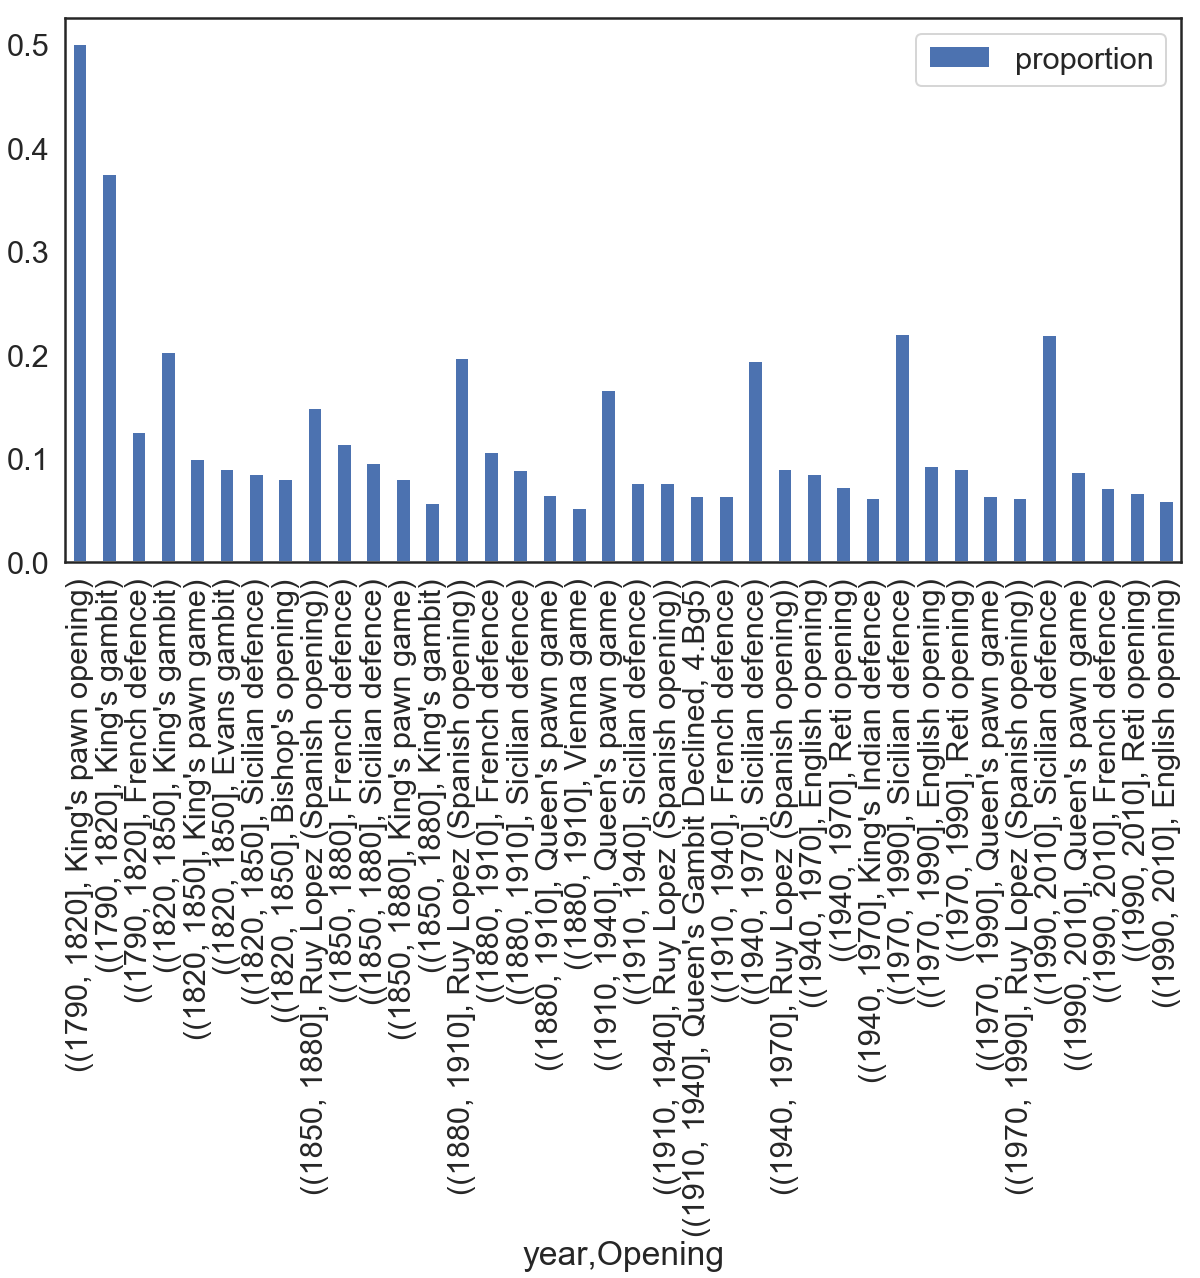

In [282]:
proportions.plot.bar(y='proportion', figsize=(20,10))

In [306]:
means = dfdates.groupby('Opening').describe()['len']

In [311]:
l = means.nlargest(5,'mean')
s = means.nsmallest(5,'mean')
lenstats = pd.concat([l,s])

In [330]:
ddf = dfdates[dfdates.Opening.isin(lenstats.index)]
ddf

,index,date,result,welo,belo,len,date_c,resu_c,welo_c,belo_c,edate_c,setup,fen,resu2_c,oyrange,bad_len,Game,Opening,year
7,7,1999.11.20,1-0,2851.0,NaN,71.0,date_false,result_false,welo_false,belo_true,edate_false,setup_false,fen_false,result2_false,oyrange_false,blen_false,W1.d4 B1.Nf6 W2.c4 B2.g6 W3.g3 B3.Bg7 W4.Bg2 ...,King's Indian defence,1999
18,18,2000.06.24,0-1,2851.0,2725.0,94.0,date_false,result_false,welo_false,belo_false,edate_false,setup_false,fen_false,result2_false,oyrange_false,blen_false,W1.d4 B1.Nf6 W2.Nf3 B2.g6 W3.c4 B3.Bg7 W4.Nc3...,"King's Indian, East Indian defence",2000
37,37,2000.03.04,1/2-1/2,2851.0,2725.0,76.0,date_false,result_false,welo_false,belo_false,edate_false,setup_false,fen_false,result2_false,oyrange_false,blen_false,W1.d4 B1.Nf6 W2.Nf3 B2.g6 W3.c4 B3.Bg7 W4.Nc3...,"King's Indian, East Indian defence",2000
57,57,2000.05.13,1-0,2851.0,2658.0,53.0,date_false,result_false,welo_false,belo_false,edate_false,setup_false,fen_false,result2_false,oyrange_false,blen_false,W1.d4 B1.Nf6 W2.Nf3 B2.g6 W3.g3 B3.Bg7 W4.Bg2...,"King's Indian, East Indian defence",2000
100,100,2000.08.21,1-0,2849.0,NaN,69.0,date_false,result_false,welo_false,belo_true,edate_false,setup_false,fen_false,result2_false,oyrange_false,blen_false,W1.d4 B1.Nf6 W2.c4 B2.g6 W3.g3 B3.Bg7 W4.Bg2 ...,King's Indian defence,2000
107,107,2001.01.28,1/2-1/2,2849.0,2746.0,53.0,date_false,result_false,welo_false,belo_false,edate_false,setup_false,fen_false,result2_false,oyrange_false,blen_false,W1.d4 B1.Nf6 W2.c4 B2.e6 W3.g3 B3.d5 W4.Bg2 B...,"Catalan, closed",2001
121,121,2000.11.02,1/2-1/2,2849.0,2770.0,76.0,date_false,result_false,welo_false,belo_false,edate_false,setup_false,fen_false,result2_false,oyrange_false,blen_false,W1.d4 B1.Nf6 W2.c4 B2.e6 W3.g3 B3.d5 W4.Bg2 B...,"Catalan, closed",2000
125,125,2000.08.21,1-0,2849.0,NaN,53.0,date_false,result_false,welo_false,belo_true,edate_false,setup_false,fen_false,result2_false,oyrange_false,blen_false,W1.e4 B1.b6 W2.d4 B2.Ba6 W3.Bxa6 B3.Nxa6 W4.N...,King's pawn opening,2000
129,129,2000.08.21,1-0,2849.0,NaN,61.0,date_false,result_false,welo_false,belo_true,edate_false,setup_false,fen_false,result2_false,oyrange_false,blen_false,W1.d4 B1.Nf6 W2.c4 B2.g6 W3.Nc3 B3.Bg7 W4.e4 ...,King's Indian defence,2000
144,144,1999.08.23,1-0,2841.0,NaN,89.0,date_false,result_false,welo_false,belo_true,edate_false,setup_false,fen_false,result2_false,oyrange_false,blen_false,W1.e4 B1.d6 W2.d4 B2.Nf6 W3.f3 B3.c6 W4.c4 B4...,King's pawn opening,1999


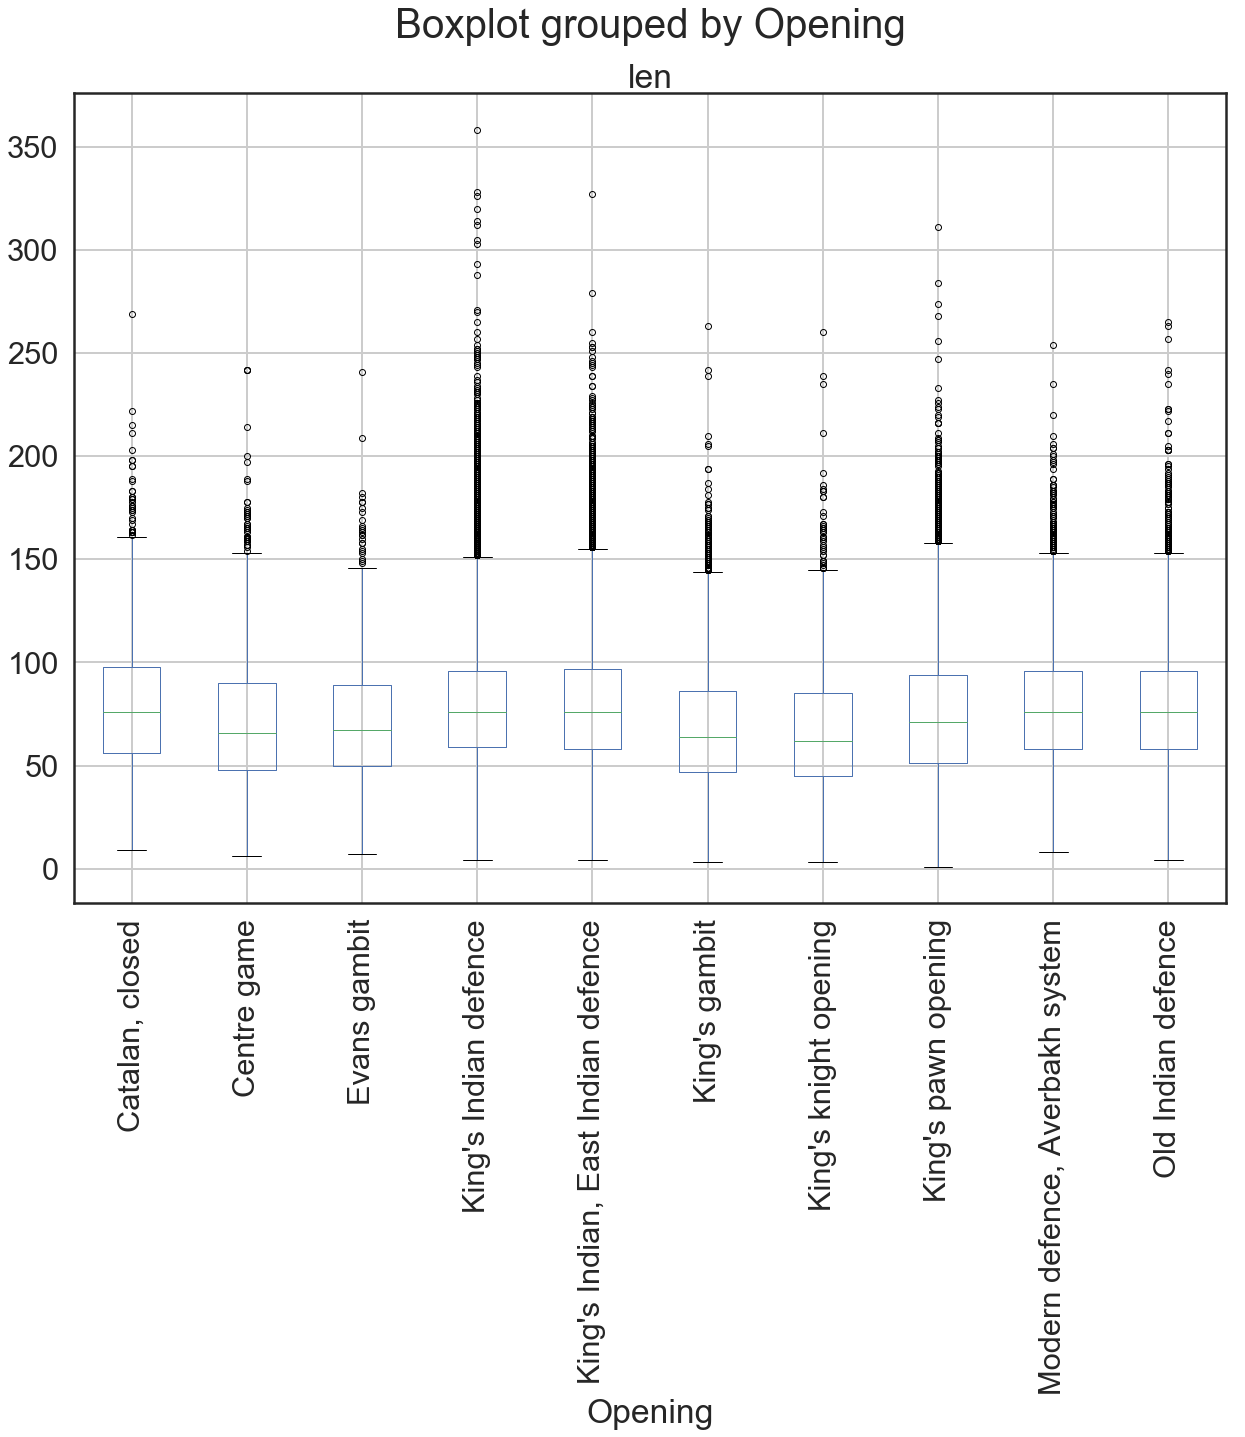

In [332]:
ddf.boxplot(by='Opening',column=['len'],rot=90,figsize=(20,15))